## Кузнецов Илья Александрович, 471 группа

# Задача 2. Сравнение методов классификации

## Задачи

[x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
[x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блакнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
[x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
[ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
[x] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
[x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
[x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
[ ] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
[x] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
[ ] * (**+2 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [1498]:
%precision 4
import warnings
warnings.filterwarnings('ignore')

## Реализация метода K ближайших соседей (KNN)

In [1499]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

import numpy as np
np.set_printoptions(precision=4)

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_neighbors=7):
        self._num_neighbors = num_neighbors

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        return self

    def predict(self, X_test):
        X_test = check_array(X_test)
        predictions = []
        for test_row in X_test:
            neighbors_indexes = self._get_neighbors_indexes(test_row)
            label = self._most_popular_label(neighbors_indexes)
            predictions.append(label)
        return predictions

    def _get_neighbors_indexes(self, test_row):
        distances = list()
        for i, train_row in enumerate(self._X_train):
            dist = self._euclidean_distance(test_row, train_row)
            distances.append((i, dist))
        distances.sort(key=lambda tupl: tupl[1])
        neighbors_indexes = list()
        for i in range(self._num_neighbors):
            neighbors_indexes.append(distances[i][0])
        return neighbors_indexes

    def _most_popular_label(self, neighbors_indexes):
        labels = []
        for i in neighbors_indexes:
            labels.append(self._y_train[i])
        label = max(set(labels), key=labels.count)
        return label

    def _euclidean_distance(self, row1, row2):
        distance = 0.0
        for i in range(len(row1) - 1):
            distance += (row1[i] - row2[i]) ** 2
        return np.sqrt(distance)

    def get_params(self, deep=True):
        return {"num_neighbors": self._num_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [1500]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

iris = load_iris()

data = iris.data
target = iris.target

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.5)

classifier = KNNClassifier()

classifier = classifier.fit(train_data, train_target)

predictions = classifier.predict(test_data)

accuracy = accuracy_score(test_target, predictions)

accuracy

0.9467

# Реализация метода опорных векторов (SVM)

In [1501]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha_value=1E-3, lamda_value=1E-3, num_iterations=1000):
        self._alpha_value = alpha_value
        self._lamda_value = lamda_value
        self._num_iterations = num_iterations

    def fit(self, X_train, y_train):
        X_train, y_train = check_X_y(X_train, y_train)
        self._X_train = X_train
        self._y_train = y_train
        for _ in range(self._num_iterations):
            self._update_weights()
        return self

    def _update_weights(self):
        y_train_labels = np.where(self._y_train <= -1, 0, 1)
        self.w = np.zeros(self._X_train.shape[1])
        self.b = 0
        for i, train_row in enumerate(self._X_train):
            dw = 0; db = 0
            if y_train_labels[i] * (np.dot(train_row, self.w) - self.b) >= 1:
                dw = 2 * self._lamda_value * self.w
                db = 0
            else:
                dw = 2 * self._lamda_value * self.w - np.dot(train_row, y_train_labels[i])
                db = y_train_labels[i]
            self.w = self.w - self._alpha_value * dw
            self.b = self.b - self._alpha_value * db

    def predict(self, X_test):
        X_test = check_array(X_test)
        labels = np.sign(np.dot(X_test, self.w) - self.b)
        predictions = np.where(labels <= -1, 0, 1)
        return predictions

    def get_params(self, deep=True):
        return {"alpha_value": self._alpha_value,
                "num_iterations": self._num_iterations,
                "lamda_value": self._lamda_value}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [1502]:
iris = load_iris()

data = iris.data
target = iris.target

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.5)

classifier = SVMClassifier()

classifier = classifier.fit(train_data, train_target)

predictions = classifier.predict(test_data)

accuracy = accuracy_score(test_target, predictions)

accuracy

0.3333

## Датасет

Этот набор данных содержит информацию о заболеваниях сердца у пациентов.

Признаки:
- **age** - возраст в годах,
- **sex** - (1 = мужчина; 0 = женщина),
- **cp** - тип боли в груди,
- **trestbps** - артериальное давление в состоянии покоя при поступлении в больницу (в мм рт. ст.),
- **chol** - холестерин в крови (в мг./дл.),
- **fbs** - (сахар в крови натощак > 120 мг/дл) (1 = истинно; 0 = ложно),
- **restecg** - результаты электрокардиографии в состоянии покоя,
- **thalach** - достигнутая максимальная частота сердечных сокращений,
- **exang** - стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет),
- **oldpeak** - депрессия ST, вызванная физической нагрузкой по сравнению с покоем,
- **slope** - наклон сегмента ST пиковой физической нагрузки,
- **ca** - количество крупных сосудов (0 - 3), окрашенных при флоуроскопии,
- **thal** - (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект).

Целевой признак:
- **target** - есть болезнь или нет (1 = да; 0 = нет).

In [1503]:
import pandas as pd
pd.set_option('display.precision', 4)

df = pd.read_csv('../data/heart_disease/heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [1504]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Пропущенных значений в данных нет, поэтому дополнительно их чистить или дополнять не требуется.
Выборка обладает категориальными признаками, некоторые из них в дальнейшем нужно будет преобразовать в количественные для решения задачи классификации.
В данных с виду не наблюдается явно лишних признаков.

## Разведочный анализ (EDA)

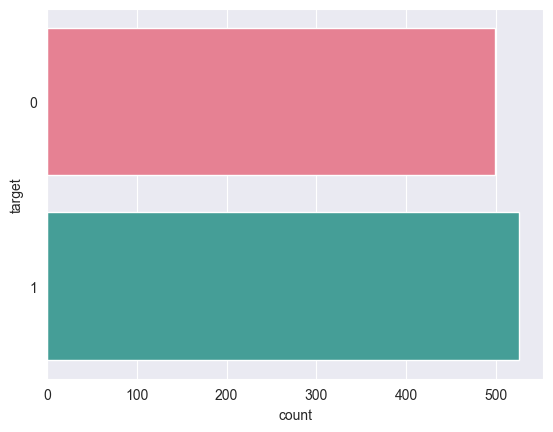

In [1505]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(data=df, y="target", palette="husl")
plt.show()

In [1506]:
df.target.value_counts()

1    526
0    499
Name: target, dtype: int64

Количество пациентов с заболеванием серца в выборке незначительно больше (на 27 человек), поэтому в целом данные сбалансированы.

In [1507]:
# TODO

Изучим корреляционную карту данного датасета.

<AxesSubplot: >

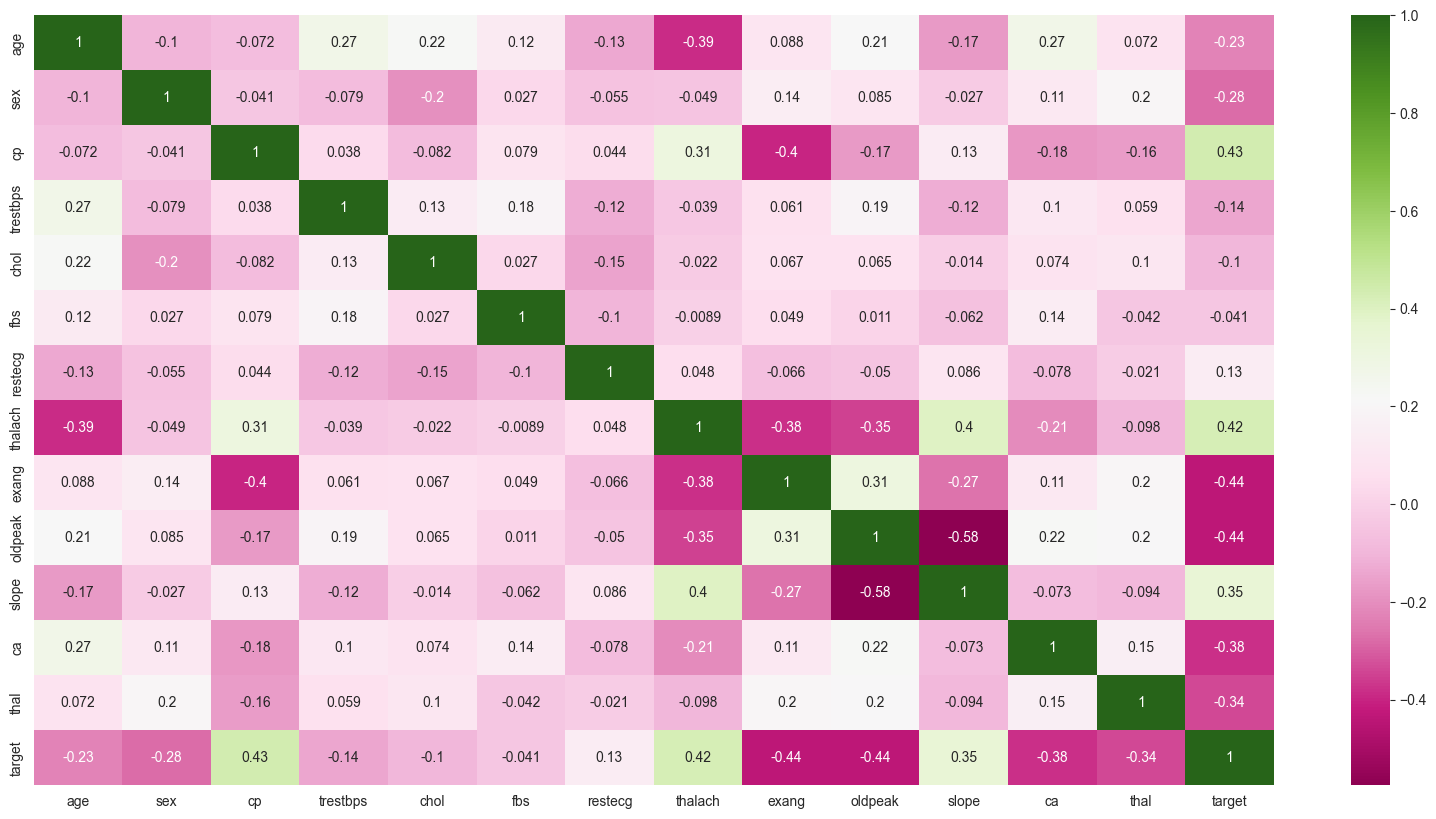

In [1508]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(), annot=True, cmap="PiYG")

Признаки **cp**, **thalach** и **slope** имеют наибольшую корреляцию с целевым признаком **target**.

## Преобразование признаков (Feature Engineering)

В датасете содержатся категориальные признаки **cp**, **slope**, и **thal**. Закодируем их.

In [1509]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1).drop(columns = ['cp', 'thal', 'slope'])
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,140,221,0,1,164,1,0.0,0,...,1,0,0,0,0,1,0,0,0,1
1021,60,1,125,258,0,0,141,1,2.8,1,...,0,0,0,0,0,0,1,0,1,0
1022,47,1,110,275,0,0,118,1,1.0,1,...,0,0,0,0,0,1,0,0,1,0
1023,50,0,110,254,0,0,159,0,0.0,0,...,0,0,0,0,0,1,0,0,0,1


## Разделение выборки на тренировочную и тестовую

In [1510]:
from sklearn.model_selection import train_test_split

x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=19)

## Масштабирование признаков

In [1511]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_train_scaled

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,-0.8156,0.6795,-1.1296,-0.8128,-0.4281,0.8926,-0.2684,-0.7123,-0.8377,-0.7357,...,-0.4439,-0.6187,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
1,0.2929,0.6795,-0.2065,-0.3279,-0.4281,-0.9939,0.0384,-0.7123,-0.5865,0.2114,...,-0.4439,1.6163,-0.2885,-0.0859,-0.2438,-1.0761,1.2247,-0.281,1.0526,-0.9090
2,1.8448,-1.4717,-1.1296,-1.8795,-0.4281,0.8926,-1.0571,-0.7123,0.4181,-0.7357,...,-0.4439,-0.6187,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,1.0526,-0.9090
3,-1.5915,0.6795,-1.2450,-1.5304,-0.4281,-0.9939,-1.5391,1.4039,0.7529,-0.7357,...,-0.4439,-0.6187,-0.2885,-0.0859,-0.2438,-1.0761,1.2247,-0.281,1.0526,-0.9090
4,0.8472,0.6795,-0.2065,-0.7352,2.3360,-0.9939,-0.3998,-0.7123,-0.9214,-0.7357,...,2.2526,-0.6187,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.4038,0.6795,0.4858,-0.6770,2.3360,-0.9939,0.6957,-0.7123,-0.9214,-0.7357,...,-0.4439,1.6163,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
816,-1.2589,0.6795,-0.0911,1.3399,-0.4281,0.8926,0.5642,-0.7123,0.6692,0.2114,...,-0.4439,1.6163,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
817,0.2929,0.6795,-0.4373,0.2927,-0.4281,0.8926,-0.3560,-0.7123,-0.6702,-0.7357,...,2.2526,-0.6187,-0.2885,-0.0859,-0.2438,-1.0761,1.2247,-0.281,-0.9500,1.1001
818,1.2906,0.6795,1.6397,-0.3473,-0.4281,-0.9939,-0.4875,-0.7123,1.0041,-0.7357,...,-0.4439,-0.6187,-0.2885,-0.0859,4.1020,-1.0761,-0.8165,-0.281,-0.9500,1.1001


In [1512]:
x_test_scaled

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,0.6255,-1.4717,1.0628,-0.1146,-0.4281,0.8926,0.9586,-0.7123,-0.1679,-0.7357,...,-0.4439,-0.6187,3.4664,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
1,0.9580,-1.4717,0.1974,0.1181,-0.4281,-0.9939,1.0024,-0.7123,-0.9214,-0.7357,...,-0.4439,1.6163,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
2,0.2929,0.6795,-0.4373,0.2927,-0.4281,0.8926,-0.3560,-0.7123,-0.6702,-0.7357,...,2.2526,-0.6187,-0.2885,-0.0859,-0.2438,-1.0761,1.2247,-0.281,-0.9500,1.1001
3,-1.8132,0.6795,0.3704,-1.3752,-0.4281,0.8926,1.0462,-0.7123,-0.9214,3.0527,...,-0.4439,1.6163,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
4,1.6231,-1.4717,0.4858,-0.1340,-0.4281,0.8926,0.0822,-0.7123,0.5855,1.1585,...,-0.4439,-0.6187,3.4664,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.5146,0.6795,1.8705,-1.3558,2.3360,-0.9939,-2.5908,-0.7123,-0.0842,1.1585,...,-0.4439,-0.6187,-0.2885,-0.0859,4.1020,-1.0761,-0.8165,-0.281,1.0526,-0.9090
201,0.8472,-1.4717,-0.4373,-0.7158,-0.4281,0.8926,0.6080,-0.7123,-0.9214,-0.7357,...,-0.4439,-0.6187,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001
202,-1.0373,0.6795,-1.2450,0.3508,-0.4281,0.8926,-0.7504,-0.7123,0.0832,-0.7357,...,-0.4439,-0.6187,3.4664,-0.0859,-0.2438,-1.0761,1.2247,-0.281,1.0526,-0.9090
203,-1.1481,0.6795,-0.6681,-0.5025,-0.4281,0.8926,0.9148,-0.7123,-0.9214,-0.7357,...,2.2526,-0.6187,-0.2885,-0.0859,-0.2438,0.9293,-0.8165,-0.281,-0.9500,1.1001


## Подбор оптимальных признаков (RFE)

In [1513]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import RidgeClassifierCV

rfecv = RFECV(estimator=RidgeClassifierCV())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])
print("Optimal features: ", rfecv.n_features_)
print("Selected features: ", selected_features)

Optimal features:  9
Selected features:  ['sex', 'thalach', 'exang', 'oldpeak', 'ca', 'cp_0', 'thal_2', 'thal_3', 'slope_1']


Удалим признаки, не входящие в данный список.

In [1514]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled

,sex,thalach,exang,oldpeak,ca,cp_0,thal_2,thal_3,slope_1
0,0.6795,-0.2684,-0.7123,-0.8377,-0.7357,1.0373,0.9293,-0.8165,-0.9500
1,0.6795,0.0384,-0.7123,-0.5865,0.2114,-0.9641,-1.0761,1.2247,1.0526
2,-1.4717,-1.0571,-0.7123,0.4181,-0.7357,1.0373,0.9293,-0.8165,1.0526
3,0.6795,-1.5391,1.4039,0.7529,-0.7357,1.0373,-1.0761,1.2247,1.0526
4,0.6795,-0.3998,-0.7123,-0.9214,-0.7357,-0.9641,0.9293,-0.8165,-0.9500
...,...,...,...,...,...,...,...,...,...
815,0.6795,0.6957,-0.7123,-0.9214,-0.7357,-0.9641,0.9293,-0.8165,-0.9500
816,0.6795,0.5642,-0.7123,0.6692,0.2114,-0.9641,0.9293,-0.8165,-0.9500
817,0.6795,-0.3560,-0.7123,-0.6702,-0.7357,-0.9641,-1.0761,1.2247,-0.9500
818,0.6795,-0.4875,-0.7123,1.0041,-0.7357,1.0373,-1.0761,-0.8165,-0.9500


In [1515]:
x_test_scaled

,sex,thalach,exang,oldpeak,ca,cp_0,thal_2,thal_3,slope_1
0,-1.4717,0.9586,-0.7123,-0.1679,-0.7357,-0.9641,0.9293,-0.8165,-0.9500
1,-1.4717,1.0024,-0.7123,-0.9214,-0.7357,-0.9641,0.9293,-0.8165,-0.9500
2,0.6795,-0.3560,-0.7123,-0.6702,-0.7357,-0.9641,-1.0761,1.2247,-0.9500
3,0.6795,1.0462,-0.7123,-0.9214,3.0527,-0.9641,0.9293,-0.8165,-0.9500
4,-1.4717,0.0822,-0.7123,0.5855,1.1585,-0.9641,0.9293,-0.8165,-0.9500
...,...,...,...,...,...,...,...,...,...
200,0.6795,-2.5908,-0.7123,-0.0842,1.1585,1.0373,-1.0761,-0.8165,1.0526
201,-1.4717,0.6080,-0.7123,-0.9214,-0.7357,1.0373,0.9293,-0.8165,-0.9500
202,0.6795,-0.7504,-0.7123,0.0832,-0.7357,-0.9641,-1.0761,1.2247,1.0526
203,0.6795,0.9148,-0.7123,-0.9214,-0.7357,-0.9641,0.9293,-0.8165,-0.9500


## Подбор оптимальных гиперпараметров и кросс-валидация

### Собственная реализация KNNClassifier

In [1516]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(5, shuffle=True, random_state=19)

param_grid = [{"num_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}]

searcher = GridSearchCV(KNNClassifier(), param_grid=param_grid,
                        cv=cv, verbose=5)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_num_neighbors = searcher.best_params_["num_neighbors"]
print("Optimal num_neighbors =", optimal_num_neighbors)
print("Optimal score =", searcher.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...................num_neighbors=1;, score=0.909 total time=   0.6s
[CV 2/5] END ...................num_neighbors=1;, score=0.915 total time=   0.6s
[CV 3/5] END ...................num_neighbors=1;, score=0.854 total time=   0.6s
[CV 4/5] END ...................num_neighbors=1;, score=0.848 total time=   0.5s
[CV 5/5] END ...................num_neighbors=1;, score=0.933 total time=   0.5s
[CV 1/5] END ...................num_neighbors=3;, score=0.909 total time=   0.5s
[CV 2/5] END ...................num_neighbors=3;, score=0.915 total time=   0.5s
[CV 3/5] END ...................num_neighbors=3;, score=0.854 total time=   0.5s
[CV 4/5] END ...................num_neighbors=3;, score=0.848 total time=   0.5s
[CV 5/5] END ...................num_neighbors=3;, score=0.933 total time=   0.5s
[CV 1/5] END ...................num_neighbors=5;, score=0.909 total time=   0.6s
[CV 2/5] END ...................num_neighbors=5;

### Собственная реализация SVMClassifier

In [1517]:
# param_grid = [{"alpha_value": [1E-1, 1E-2, 1E-3],
#                "lamda_value": [1E-1, 1E-2, 1E-3],
#                "num_iterations": [100, 500, 1000]}]
#
# searcher = GridSearchCV(SVMClassifier(), param_grid=param_grid,
#                         cv=cv, verbose=5)
#
# searcher = searcher.fit(x_train_scaled, y_train)
#
# optimal_alpha_value = searcher.best_params_["alpha_value"]
# print("Optimal alpha_value =", optimal_alpha_value)
# optimal_lamda_value = searcher.best_params_["lamda_value"]
# print("Optimal lamda_value =", optimal_lamda_value)
# optimal_num_iterations = searcher.best_params_["num_iterations"]
# print("Optimal num_iterations =", optimal_num_iterations)
# print("Optimal score =", searcher.best_score_)

### Библиотечная реализация LogisticRegression

In [1518]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [1E-3, 1E-1, 1, 1E+1, 1E+3]}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

searcher = GridSearchCV(LogisticRegression(random_state=19), param_grid=param_grid,
                        scoring=scoring, cv=cv, refit='Accuracy')

searcher = searcher.fit(x_train_scaled, y_train)

optimal_logreg_c = searcher.best_params_["C"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 0.1}
Optimal score = 0.8646341463414634


### Библиотечная реализация SVM

In [1519]:
from sklearn.svm import SVC

param_grid = {"kernel": ["linear", "rbf"],
              "C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "gamma": ["scale", "auto", 1E-3, 1E-1, 1, 1E+1, 1E+3]}

searcher = GridSearchCV(SVC(random_state=19), param_grid=param_grid,
                        cv=cv)

searcher = searcher.fit(x_train_scaled, y_train)

optimal_kernel = searcher.best_params_["kernel"]
optimal_svm_c = searcher.best_params_["C"]
optimal_gamma = searcher.best_params_["gamma"]
print("Optimal params =", searcher.best_params_)
print("Optimal score =", searcher.best_score_)

Optimal params = {'C': 0.5, 'gamma': 1000.0, 'kernel': 'rbf'}
Optimal score = 0.9731707317073169


### Библиотечная реализация KNN

In [1520]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
               "weights": ['distance', 'uniform']}]
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

searcher = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid,
                        scoring=scoring, cv=cv, refit='Accuracy')

searcher = searcher.fit(x_train_scaled, y_train)

optimal_n_neighbors = searcher.best_params_["n_neighbors"]
optimal_weights = searcher.best_params_["weights"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'n_neighbors': 7, 'weights': 'distance'}
Optimal score = 0.9902439024390244


### Библиотечная реализация Naive Bayes

In [1521]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{"priors": [[0.5, 0.5], [0.33, 0.67], [0.67, 0.33], [0.25, 0.75], [0.75, 0.25]],
               "var_smoothing": np.logspace(0, -10, num=100)}]
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

searcher = GridSearchCV(GaussianNB(), param_grid=param_grid,
                        scoring=scoring, cv=cv, refit='Accuracy')

searcher = searcher.fit(x_train_scaled, y_train)

optimal_priors = searcher.best_params_["priors"]
optimal_var_smoothing = searcher.best_params_["var_smoothing"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'priors': [0.67, 0.33], 'var_smoothing': 0.6280291441834253}
Optimal score = 0.8585365853658538


### Библиотечная реализация Decision Tree

In [1522]:
from sklearn.tree import DecisionTreeClassifier

param_grid = [{"criterion": ["gini", "entropy", "log_loss"],
               "splitter": ["best", "random"],
               "max_depth": [10, 20, 30, 40, 50],
               "min_samples_split": [2, 4, 6, 8, 10],
               "min_samples_leaf": [2, 4, 6, 8, 10],
               "max_features": [2, 4, 6, 8, 10]}]
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

searcher = GridSearchCV(DecisionTreeClassifier(random_state=19), param_grid=param_grid,
                        scoring=scoring, cv=cv, refit='Accuracy')

searcher = searcher.fit(x_train_scaled, y_train)

optimal_criterion = searcher.best_params_["criterion"]
optimal_splitter = searcher.best_params_["splitter"]
optimal_max_depth = searcher.best_params_["max_depth"]
optimal_min_samples_split = searcher.best_params_["min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["min_samples_leaf"]
optimal_max_features = searcher.best_params_["max_features"]
print("Optimal params =", str(searcher.best_params_))
print('Optimal score =', searcher.best_score_)

Optimal params = {'criterion': 'entropy', 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Optimal score = 0.9487804878048781


## Тестирование обученных моделей

In [1523]:
scores = {}

### Собственная реализация KNNClassifier

In [1524]:
from sklearn.metrics import accuracy_score

classifier = KNNClassifier(num_neighbors=optimal_num_neighbors)

classifier = classifier.fit(x_train_scaled, y_train)

y_test_pred = classifier.predict(x_test_scaled)
score = accuracy_score(y_test, y_test_pred)

scores['OWN_KNN'] = score
print("OWN_KNN score =", score)

OWN_KNN score = 1.0


### Собственная реализация SVMClassifier

In [1525]:
# classifier = SVMClassifier(alpha_value=optimal_alpha_value,
#                            lamda_value=optimal_lamda_value,
#                            num_iterations=optimal_num_iterations)
#
# classifier = classifier.fit(x_train_scaled, y_train)
#
# y_test_pred = classifier.predict(x_test_scaled)
# score = accuracy_score(y_test, y_test_pred)
#
# scores['OWN_SVM'] = score
# print("OWN_SVM score =", score)

### Библиотечная реализация LogisticRegression

In [1526]:
classifier = LogisticRegression(C=optimal_logreg_c, random_state=19)

classifier = classifier.fit(x_train_scaled, y_train)

y_test_pred = classifier.predict(x_test_scaled)
score = accuracy_score(y_test, y_test_pred)

scores['LIB_LOGREG'] = score
print("LIB_LOGREG score =", score)

LIB_LOGREG score = 0.8682926829268293


### Библиотечная реализация SVM

In [1527]:
classifier = SVC(kernel=optimal_kernel, C=optimal_svm_c, gamma=optimal_gamma, random_state=19)

classifier = classifier.fit(x_train_scaled, y_train)

y_test_pred = classifier.predict(x_test_scaled)
score = accuracy_score(y_test, y_test_pred)

scores['LIB_SVM'] = score
print("LIB_SVM score =", score)

LIB_SVM score = 1.0


### Библиотечная реализация KNN

In [1528]:
classifier = KNeighborsClassifier(n_neighbors=optimal_n_neighbors)

classifier = classifier.fit(x_train_scaled, y_train)

y_test_pred = classifier.predict(x_test_scaled)
score = accuracy_score(y_test, y_test_pred)

scores['LIB_KNN'] = score
print("LIB_KNN score =", score)

LIB_KNN score = 0.8536585365853658


### Библиотечная реализация Naive Bayes

In [1529]:
classifier = GaussianNB(priors=optimal_priors, var_smoothing=optimal_var_smoothing)

classifier = classifier.fit(x_train_scaled, y_train)

y_test_pred = classifier.predict(x_test_scaled)
score = accuracy_score(y_test, y_test_pred)

scores['LIB_NB'] = score
print("LIB_NB score =", score)

LIB_NB score = 0.8390243902439024


### Библиотечная реализация Decision Tree

In [1530]:
classifier = DecisionTreeClassifier(criterion=optimal_criterion, max_depth=optimal_max_depth,
                                    max_features=optimal_max_features, min_samples_leaf=optimal_min_samples_leaf,
                                    min_samples_split=optimal_min_samples_split, splitter=optimal_splitter, random_state=19)

classifier = classifier.fit(x_train_scaled, y_train)

y_test_pred = classifier.predict(x_test_scaled)
score = accuracy_score(y_test, y_test_pred)

scores['LIB_DT'] = score
print("LIB_DT score =", score)

LIB_DT score = 0.9804878048780488


## Сравнение обученных моделей

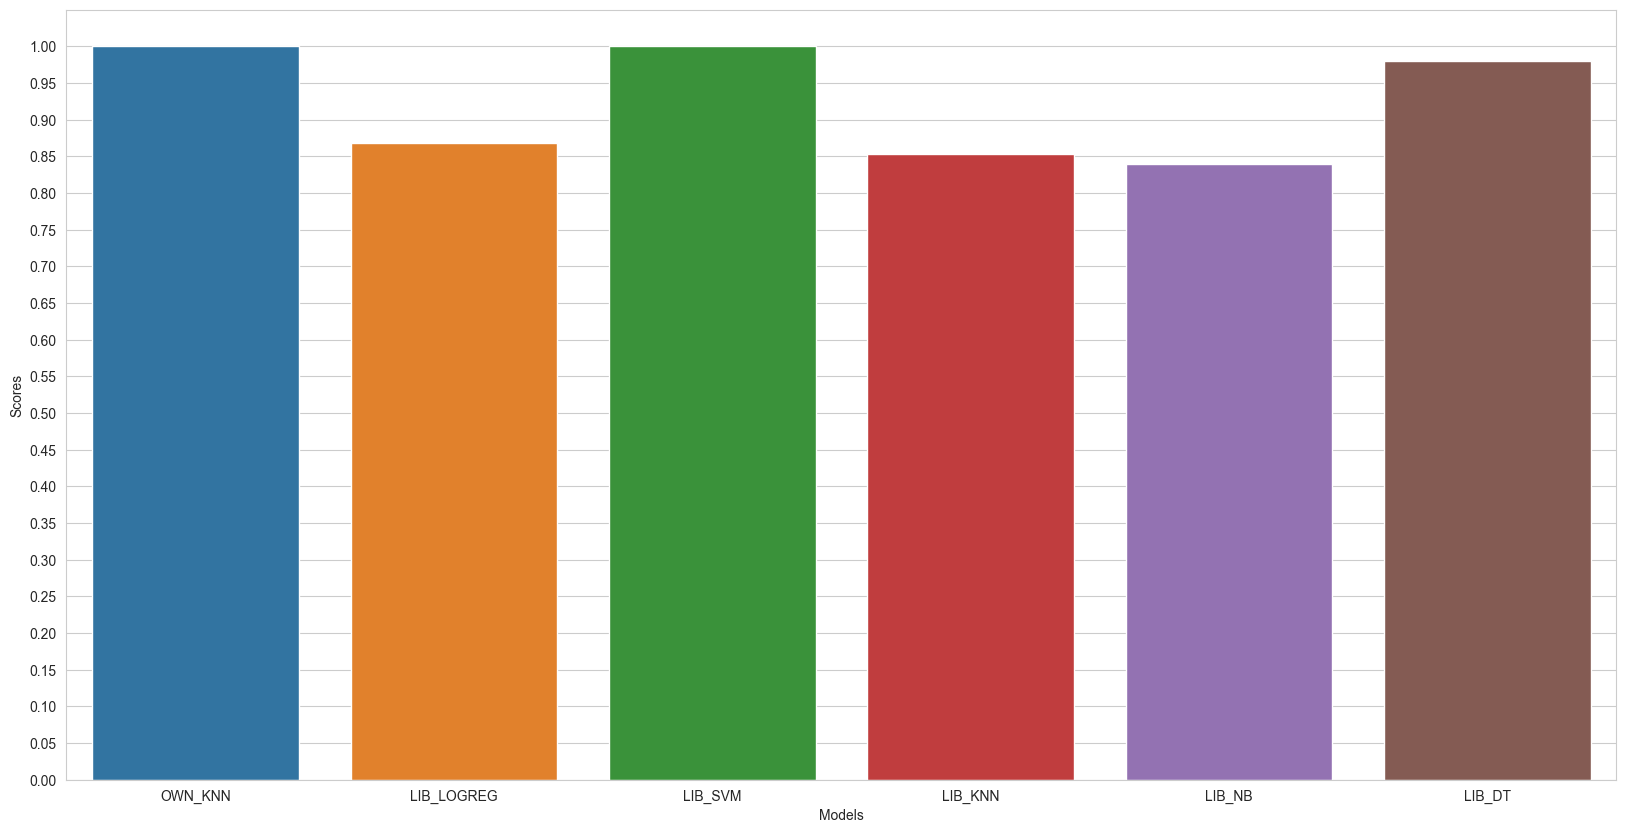

In [1541]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 10))
plt.xlabel("Models")
plt.ylabel("Scores")
plt.yticks(np.arange(0, 1.05, 0.05))

sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.show()